In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [6]:
df = pd.read_csv("Fraud Detection.csv")

In [7]:
df_reduced, _ = train_test_split(df, test_size=0.99, stratify=df['isFraud'], random_state=42)

In [8]:
df_reduced.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
5351438,375,PAYMENT,12261.57,C523354746,0.00,0.00,M1243337042,0.00,0.00,0,0
973658,44,CASH_OUT,198400.46,C1938941733,0.00,0.00,C975553845,1605780.49,1804180.95,0,0
5444705,379,CASH_OUT,241670.00,C586483587,106306.00,0.00,C535753379,110979.13,352649.13,0,0
608124,34,CASH_OUT,172353.27,C288655345,223835.10,51481.83,C1897996193,1001023.55,1173376.82,0,0
219563,13,PAYMENT,5422.60,C1648326862,169241.32,163818.72,M747983556,0.00,0.00,0,0


In [9]:
len(df_reduced)

63626

In [10]:
# Rename multiple columns
df_reduced.rename(columns={"nameOrig": "customer_id", "nameDest": "merchant_id", "oldbalanceOrg": "old_balance", "newbalanceOrig": "new_balance","oldbalanceDest":"merchant_old_balance","newbalanceDest":"merchant_new_balance"}, inplace=True)

In [11]:
df_reduced.isnull().sum()

step                    0
type                    0
amount                  0
customer_id             0
old_balance             0
new_balance             0
merchant_id             0
merchant_old_balance    0
merchant_new_balance    0
isFraud                 0
isFlaggedFraud          0
dtype: int64

In [12]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63626 entries, 5351438 to 16236
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   step                  63626 non-null  int64  
 1   type                  63626 non-null  object 
 2   amount                63626 non-null  float64
 3   customer_id           63626 non-null  object 
 4   old_balance           63626 non-null  float64
 5   new_balance           63626 non-null  float64
 6   merchant_id           63626 non-null  object 
 7   merchant_old_balance  63626 non-null  float64
 8   merchant_new_balance  63626 non-null  float64
 9   isFraud               63626 non-null  int64  
 10  isFlaggedFraud        63626 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 5.8+ MB


In [13]:
df_reduced.drop_duplicates(subset=["customer_id", "merchant_id", "amount"],inplace=True)

In [14]:
len(df_reduced)

63626

# EDA

<Axes: title={'center': 'Class Distribution'}, xlabel='Class', ylabel='Count'>

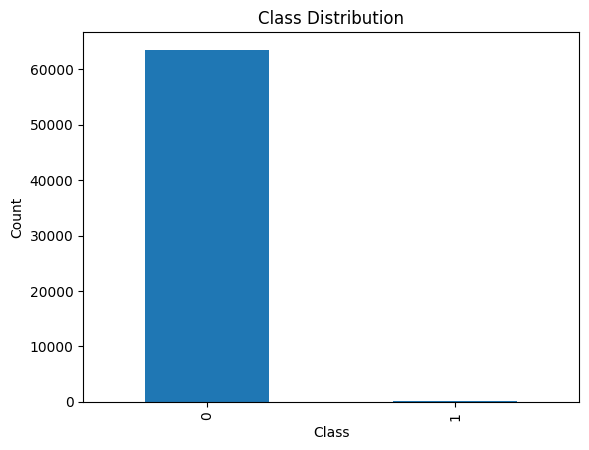

In [53]:
y.value_counts().plot(kind='bar', title='Class Distribution', xlabel='Class', ylabel='Count')

In [15]:
df_reduced['day_of_week'] = (df_reduced['step'] // 24) % 7 + 1
df_reduced['hour_of_day'] = df_reduced['step'] % 24

In [17]:
df_reduced['transaction_category'] = pd.cut(df_reduced['amount'], bins=[0, 50, 500, 5000, np.inf], labels=['Low', 'Medium', 'High', 'Very High'])

In [18]:
customer_stats = df_reduced.groupby("customer_id").agg(avg_transaction_amount=("amount","mean"),
                                              transaction_count=("customer_id","count")).reset_index()

In [19]:
df_reduced = df_reduced.merge(customer_stats,on="customer_id",how="left")

In [20]:
df_reduced.head()

,step,type,amount,customer_id,old_balance,new_balance,merchant_id,merchant_old_balance,merchant_new_balance,isFraud,isFlaggedFraud,day_of_week,hour_of_day,transaction_category,avg_transaction_amount,transaction_count
0,375,PAYMENT,12261.57,C523354746,0.00,0.00,M1243337042,0.00,0.00,0,0,2,15,Very High,12261.57,1
1,44,CASH_OUT,198400.46,C1938941733,0.00,0.00,C975553845,1605780.49,1804180.95,0,0,2,20,Very High,198400.46,1
2,379,CASH_OUT,241670.00,C586483587,106306.00,0.00,C535753379,110979.13,352649.13,0,0,2,19,Very High,241670.00,1
3,34,CASH_OUT,172353.27,C288655345,223835.10,51481.83,C1897996193,1001023.55,1173376.82,0,0,2,10,Very High,172353.27,1
4,13,PAYMENT,5422.60,C1648326862,169241.32,163818.72,M747983556,0.00,0.00,0,0,1,13,Very High,5422.60,1


In [21]:
df_reduced['amount_type_interaction'] = df_reduced['amount'] * df_reduced['type'].factorize()[0]

In [22]:
df_reduced = pd.get_dummies(df_reduced,columns=["type"])

In [24]:
df_reduced.head()

,step,amount,customer_id,old_balance,new_balance,merchant_id,merchant_old_balance,merchant_new_balance,isFraud,isFlaggedFraud,...,hour_of_day,transaction_category,avg_transaction_amount,transaction_count,amount_type_interaction,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,375,12261.57,C523354746,0.00,0.00,M1243337042,0.00,0.00,0,0,...,15,Very High,12261.57,1,0.00,False,False,False,True,False
1,44,198400.46,C1938941733,0.00,0.00,C975553845,1605780.49,1804180.95,0,0,...,20,Very High,198400.46,1,198400.46,False,True,False,False,False
2,379,241670.00,C586483587,106306.00,0.00,C535753379,110979.13,352649.13,0,0,...,19,Very High,241670.00,1,241670.00,False,True,False,False,False
3,34,172353.27,C288655345,223835.10,51481.83,C1897996193,1001023.55,1173376.82,0,0,...,10,Very High,172353.27,1,172353.27,False,True,False,False,False
4,13,5422.60,C1648326862,169241.32,163818.72,M747983556,0.00,0.00,0,0,...,13,Very High,5422.60,1,0.00,False,False,False,True,False


In [25]:
df_reduced['amount'] = pd.to_numeric(df_reduced['amount'], errors='coerce').fillna(0)
df_reduced['old_balance'] = pd.to_numeric(df_reduced['old_balance'], errors='coerce').fillna(0)
df_reduced['new_balance'] = pd.to_numeric(df_reduced['new_balance'], errors='coerce').fillna(0)
df_reduced['merchant_old_balance'] = pd.to_numeric(df_reduced['merchant_old_balance'], errors='coerce').fillna(0)
df_reduced['merchant_new_balance'] = pd.to_numeric(df_reduced['merchant_new_balance'], errors='coerce').fillna(0)

In [26]:
df_reduced['log_amount'] = np.log1p(df_reduced['amount'])
df_reduced['log_old_balance'] = np.log1p(df_reduced['old_balance'])
df_reduced['log_new_balance'] = np.log1p(df_reduced['new_balance'])
df_reduced['log_merchant_old_balance'] = np.log1p(df_reduced['merchant_old_balance'])
df_reduced['log_merchant_new_balance'] = np.log1p(df_reduced['merchant_new_balance'])

In [27]:
le = LabelEncoder()

In [28]:
df_reduced[["customer_id","merchant_id"]] = df_reduced[["customer_id","merchant_id"]].apply(lambda col: le.fit_transform(col))

In [29]:
df_reduced.head()

,step,amount,customer_id,old_balance,new_balance,merchant_id,merchant_old_balance,merchant_new_balance,isFraud,isFlaggedFraud,...,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,log_amount,log_old_balance,log_new_balance,log_merchant_old_balance,log_merchant_new_balance
0,375,12261.57,47703,0.00,0.00,41697,0.00,0.00,0,0,...,False,False,False,True,False,9.414307,0.000000,0.000000,0.000000,0.000000
1,44,198400.46,30963,0.00,0.00,38426,1605780.49,1804180.95,0,0,...,False,True,False,False,False,12.198048,0.000000,0.000000,14.289121,14.405618
2,379,241670.00,49822,106306.00,0.00,29604,110979.13,352649.13,0,0,...,False,True,False,False,False,12.395333,11.574086,0.000000,11.617106,12.773232
3,34,172353.27,40094,223835.10,51481.83,18118,1001023.55,1173376.82,0,0,...,False,True,False,False,False,12.057307,12.318669,10.849004,13.816535,13.975397
4,13,5422.60,21406,169241.32,163818.72,57859,0.00,0.00,0,0,...,False,False,False,True,False,8.598515,12.039087,12.006522,0.000000,0.000000


In [30]:
X = df_reduced.drop("isFraud", axis=1)
y = df_reduced["isFraud"]

In [31]:
X

,step,amount,customer_id,old_balance,new_balance,merchant_id,merchant_old_balance,merchant_new_balance,isFlaggedFraud,day_of_week,...,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,log_amount,log_old_balance,log_new_balance,log_merchant_old_balance,log_merchant_new_balance
0,375,12261.57,47703,0.00,0.00,41697,0.00,0.00,0,2,...,False,False,False,True,False,9.414307,0.000000,0.000000,0.000000,0.000000
1,44,198400.46,30963,0.00,0.00,38426,1605780.49,1804180.95,0,2,...,False,True,False,False,False,12.198048,0.000000,0.000000,14.289121,14.405618
2,379,241670.00,49822,106306.00,0.00,29604,110979.13,352649.13,0,2,...,False,True,False,False,False,12.395333,11.574086,0.000000,11.617106,12.773232
3,34,172353.27,40094,223835.10,51481.83,18118,1001023.55,1173376.82,0,2,...,False,True,False,False,False,12.057307,12.318669,10.849004,13.816535,13.975397
4,13,5422.60,21406,169241.32,163818.72,57859,0.00,0.00,0,1,...,False,False,False,True,False,8.598515,12.039087,12.006522,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63621,158,216803.70,35197,31471.00,0.00,3102,735043.84,951847.53,0,7,...,False,True,False,False,False,12.286752,10.356854,0.000000,13.507687,13.766161
63622,40,15490.93,12317,2246.00,0.00,56618,0.00,0.00,0,2,...,False,False,False,True,False,9.648075,7.717351,0.000000,0.000000,0.000000
63623,326,388959.69,34337,424.00,0.00,30623,2665896.64,3054856.34,0,7,...,False,True,False,False,False,12.871234,6.052089,0.000000,14.796051,14.932243
63624,372,2003.55,27577,0.00,0.00,34183,90315.02,92318.57,0,2,...,False,True,False,False,False,7.603175,0.000000,0.000000,11.411070,11.433011


In [34]:
y.unique()

array([0, 1], dtype=int64)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
print(X_train.dtypes)

step                           int64
amount                       float64
customer_id                    int32
old_balance                  float64
new_balance                  float64
merchant_id                    int32
merchant_old_balance         float64
merchant_new_balance         float64
isFlaggedFraud                 int64
day_of_week                    int64
hour_of_day                    int64
transaction_category        category
avg_transaction_amount       float64
transaction_count              int64
amount_type_interaction      float64
type_CASH_IN                    bool
type_CASH_OUT                   bool
type_DEBIT                      bool
type_PAYMENT                    bool
type_TRANSFER                   bool
log_amount                   float64
log_old_balance              float64
log_new_balance              float64
log_merchant_old_balance     float64
log_merchant_new_balance     float64
dtype: object


In [37]:
X_train = pd.get_dummies(X_train, columns=['transaction_category'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['transaction_category'], drop_first=True)

In [38]:
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [39]:
X_train.shape, X_test.shape

((50900, 27), (12726, 27))

In [40]:
non_numeric_cols = X_train.select_dtypes(include=['object']).columns
print(non_numeric_cols)

Index([], dtype='object')


In [41]:
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

In [42]:
print(X_train.shape)
print(X_test.shape)

(50900, 27)
(12726, 27)


In [44]:
X_train.value_counts(normalize=True)*100
y_train.value_counts(normalize=True)*100

isFraud
0    99.880157
1     0.119843
Name: proportion, dtype: float64

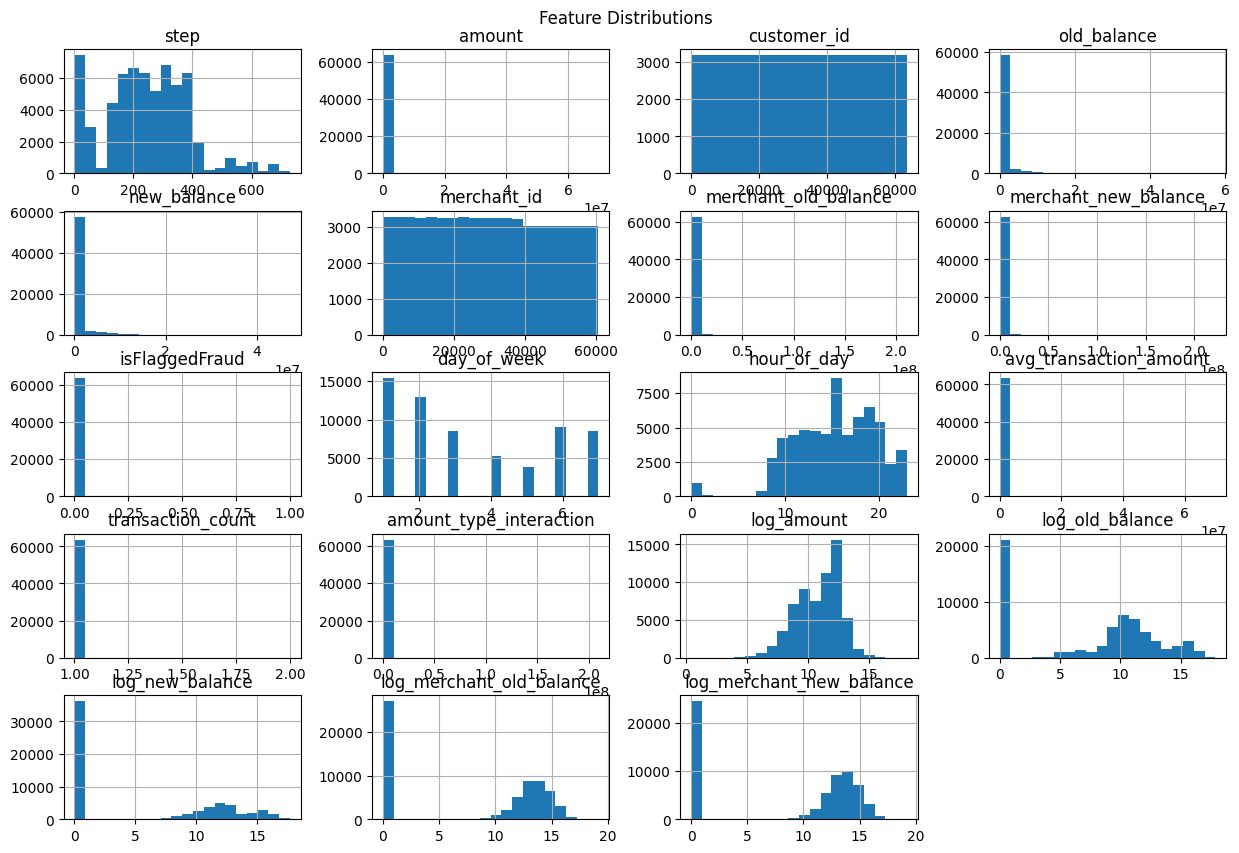

In [67]:
X.hist(figsize=(15, 10), bins=20)
plt.suptitle('Feature Distributions', y=0.92)
plt.show()

In [45]:
param_grid = {'max_depth': [5, 10, 15], 'n_estimators': [50, 100, 150]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='average_precision')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'n_estimators': [50, 100, 150]},
             scoring='average_precision')

In [46]:
model = RandomForestClassifier(max_depth=15,n_estimators=150,class_weight="balanced")

In [47]:
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

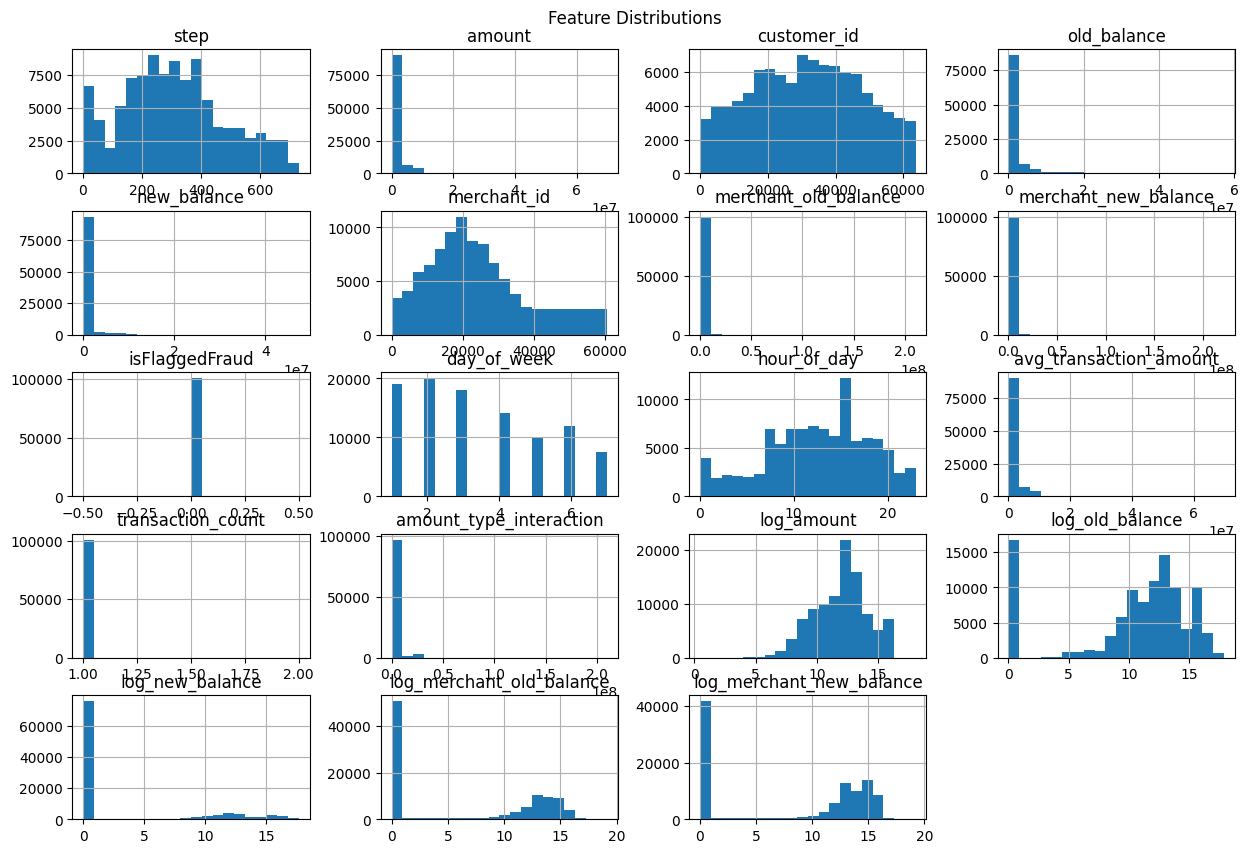

In [68]:
X_resampled.hist(figsize=(15, 10), bins=20)
plt.suptitle('Feature Distributions', y=0.92)
plt.show()

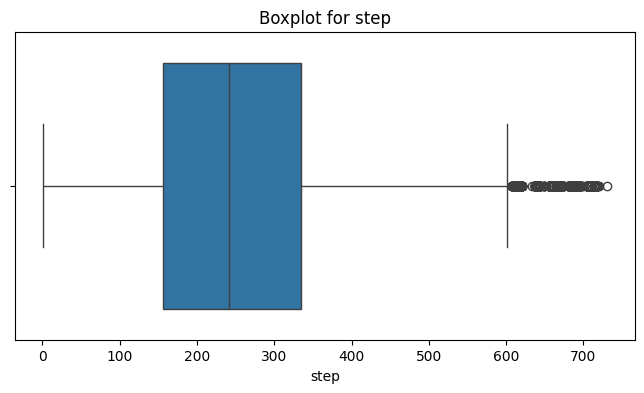

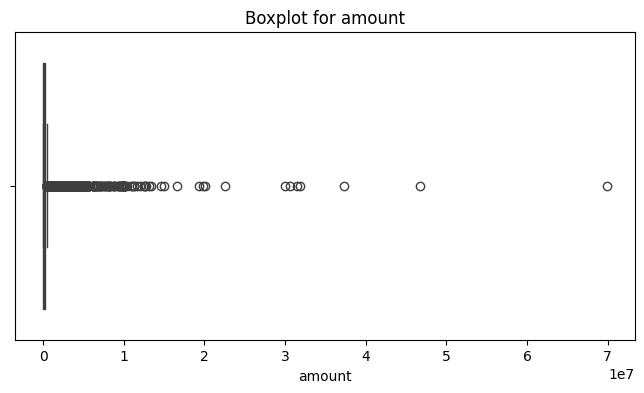

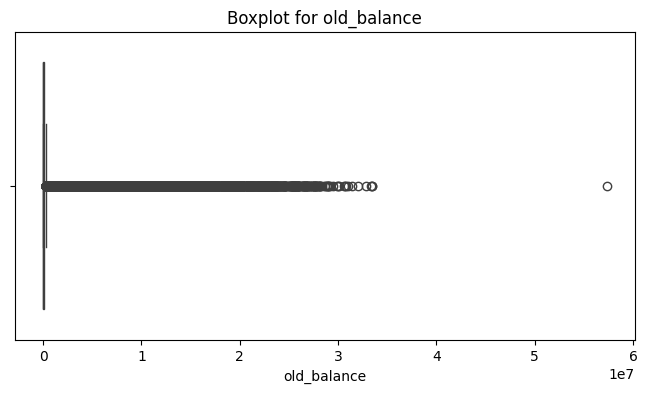

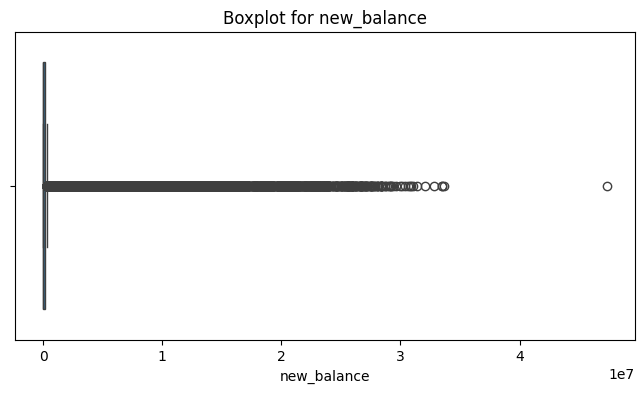

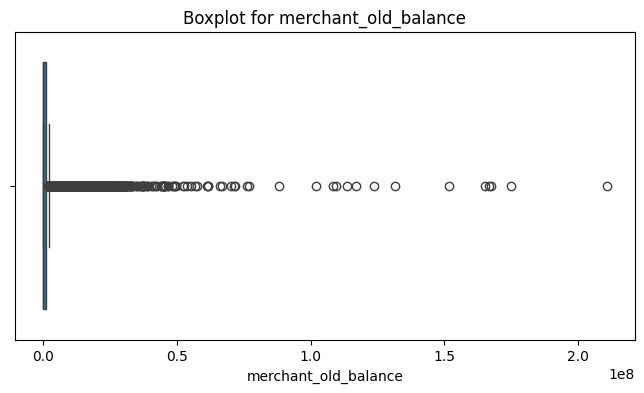

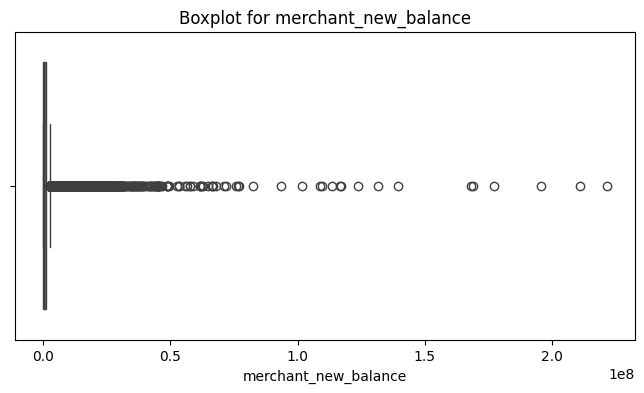

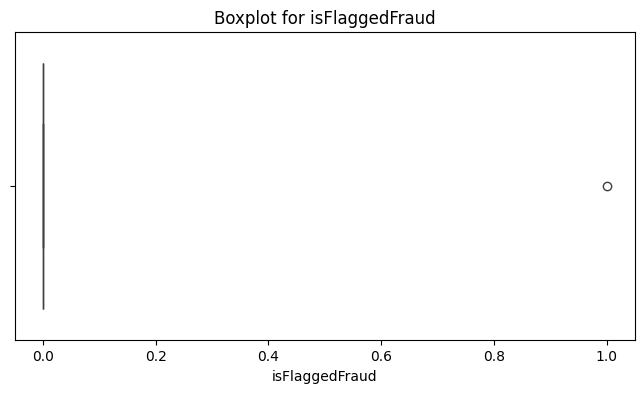

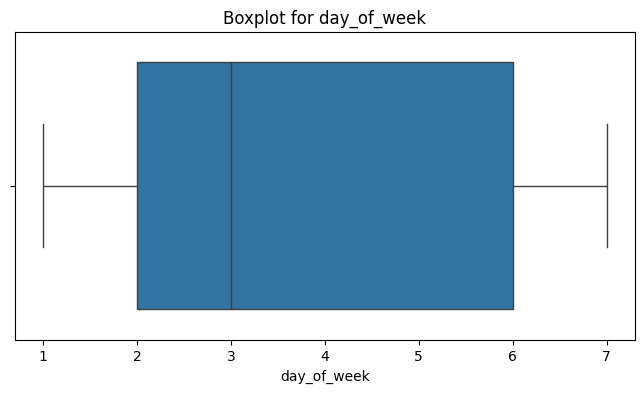

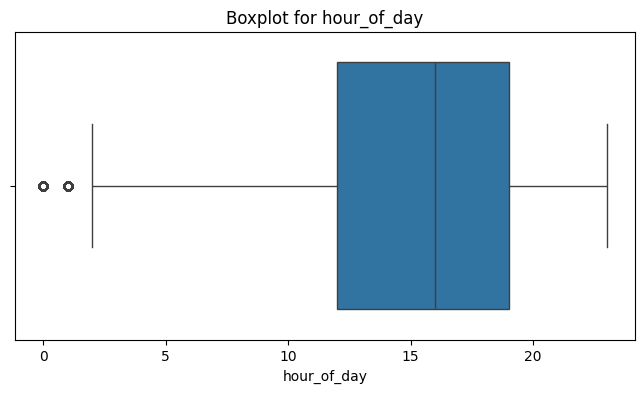

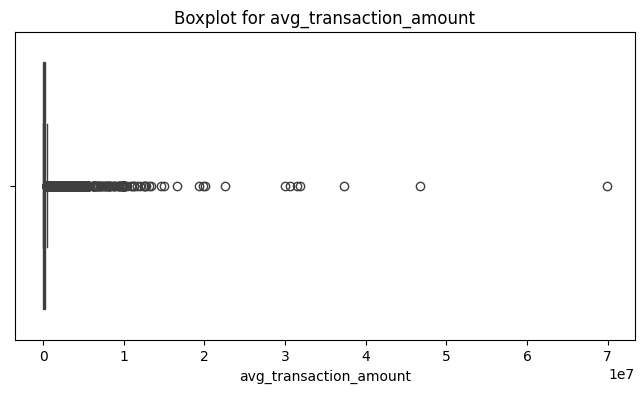

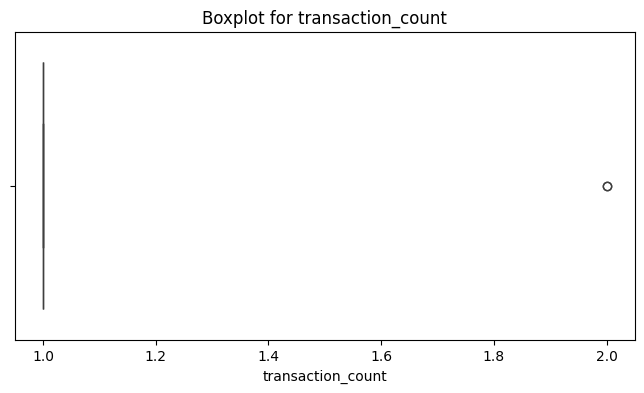

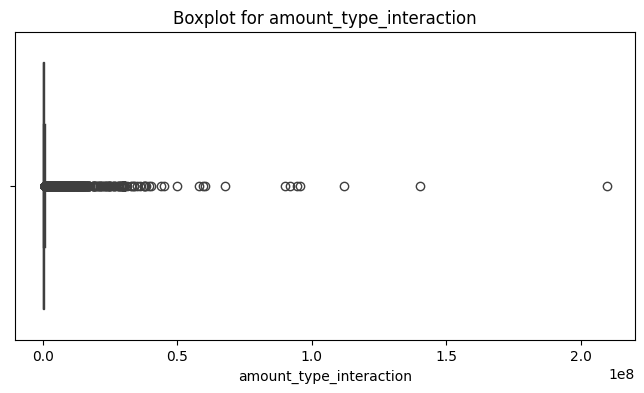

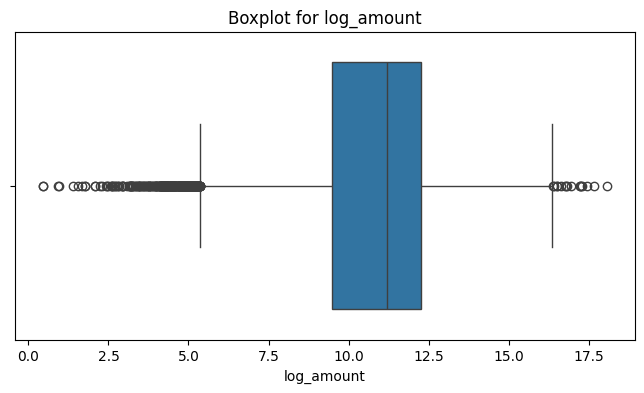

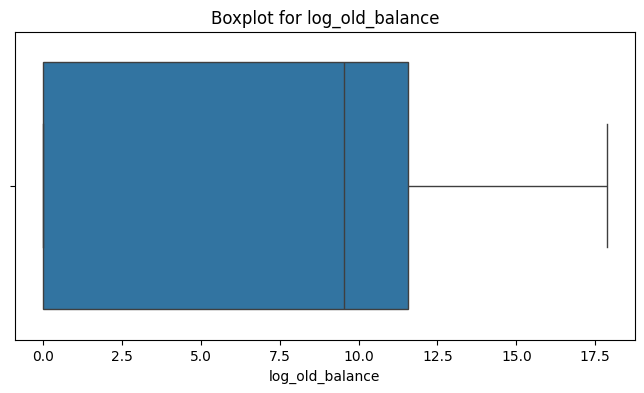

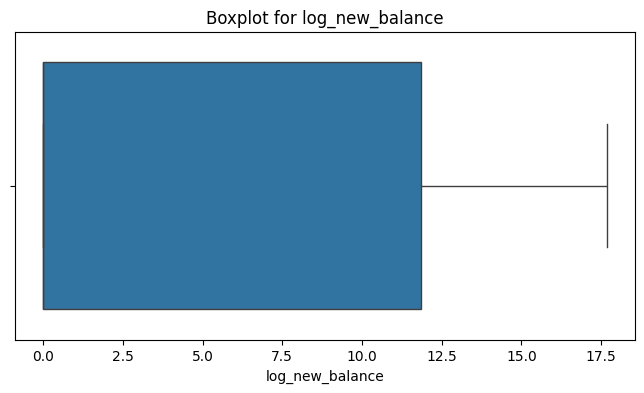

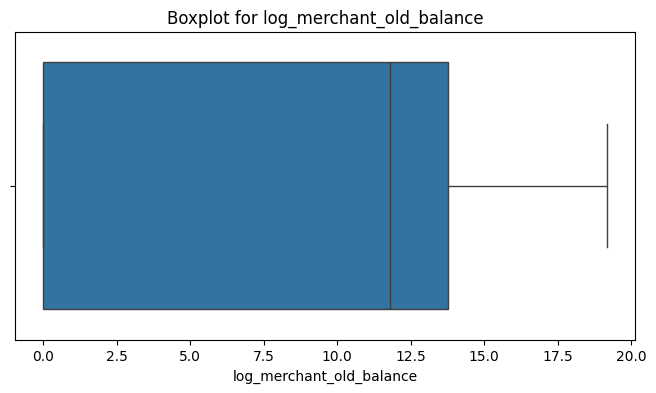

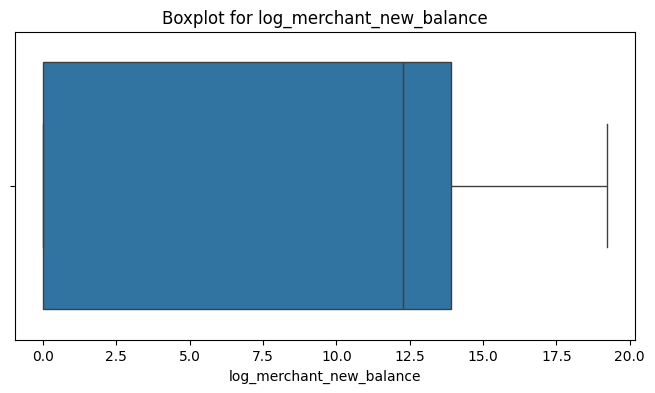

In [69]:
for column in X.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=X[column])
    plt.title(f'Boxplot for {column}')
    plt.show()

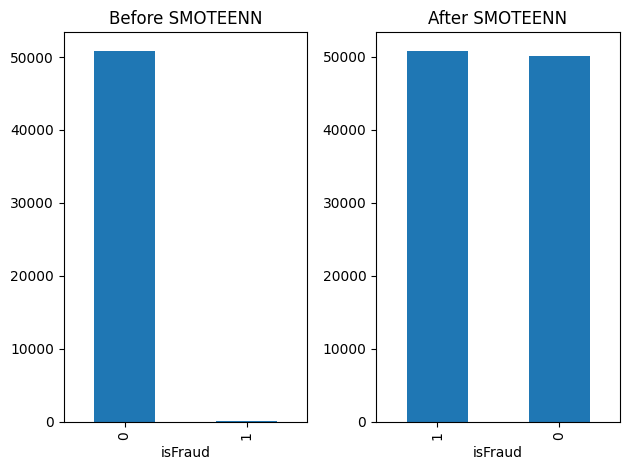

In [65]:
# Before balancing
plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', title='Before SMOTEENN')

# After balancing
plt.subplot(1, 2, 2)
pd.Series(y_resampled).value_counts().plot(kind='bar', title='After SMOTEENN')

plt.tight_layout()
plt.show()

In [64]:
X_resampled.value_counts(normalize=True)*100
y_resampled.value_counts(normalize=True)*100

isFraud
1    50.334726
0    49.665274
Name: proportion, dtype: float64

In [49]:
cv_scores = cross_val_score(model,X_resampled, y_resampled, cv=5, scoring = "f1")

In [50]:
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.99965573 0.9998033  0.99965583 0.9995575  0.99945922]
Mean CV score: 0.9996263181657431


In [51]:
print("Unique values in y_train:", y_train.unique())
print("Unique values in y_test:", y_test.unique())

Unique values in y_train: [0 1]
Unique values in y_test: [0 1]


In [52]:
model.fit(X_train, y_train)
test_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("Test set score:", test_score)

Test set score: 0.9996814152658309


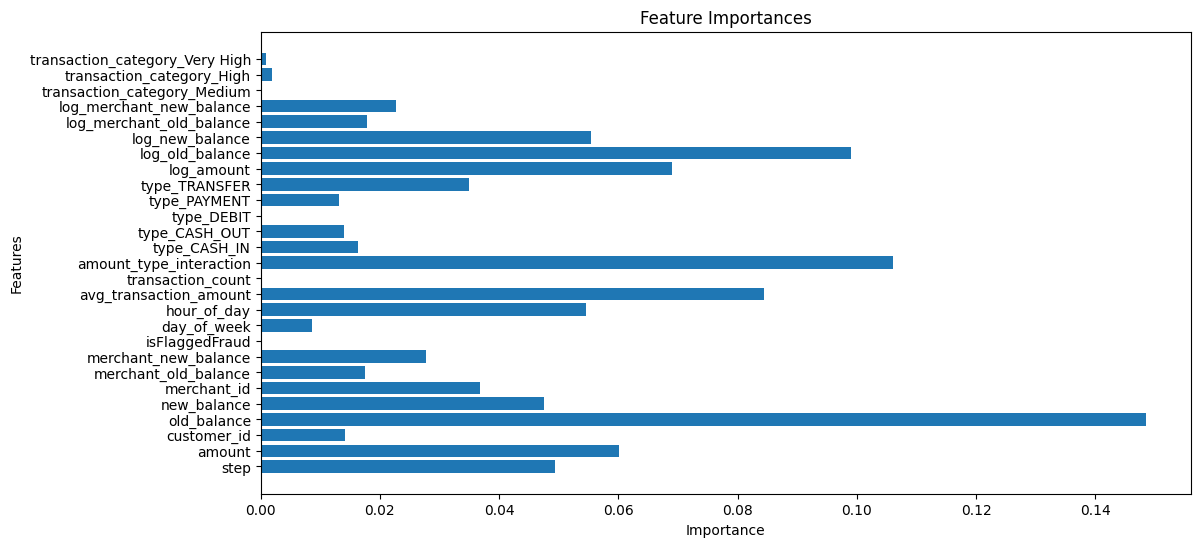

In [57]:

feature_importances = model.feature_importances_
features = X_train.columns

plt.figure(figsize=(12, 6))
plt.barh(features, feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

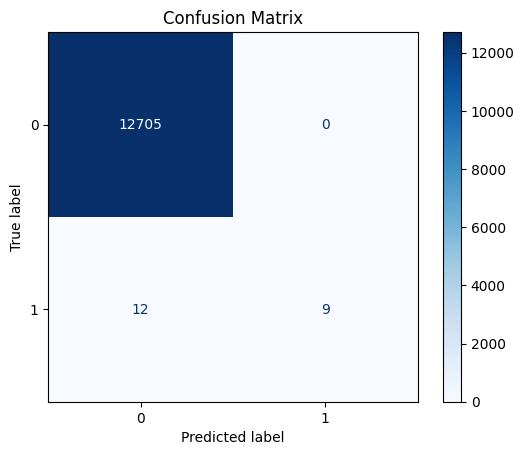

In [60]:
cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()